# Evaluating simple approximation of Non-equilibrium on  

In [145]:
using LinearAlgebra, Jevo, Jedi, Plots, DataFrames, CSV, Statistics, LambertW, Measures, Polynomials
Jedi.default_gr!()

Plots.GRBackend()

Import Metadata.

In [152]:
# Neutral Expectation
γ_0(n) = (n-1)/n

# Binding Threshold
γ_1(l, n, l_0) = γ_0(n) - l_0/l

# Binding probability
pb(γ, l, n, l_0, gap) = 1 / (1 + exp(gap * (l / l_0) * (γ - γ_1(l, n, l_0))))

# Fitness component for functional binding
F_b(γ, l, n, l_0, gap, f0) = f0 * pb(γ, l, n, l_0, gap)

# Fitness component of genomic constraint
F_c(l, l_0, fl) = - fl * l / l_0

# Total Fitness
F(γ, l, n, l_0, gap, f0, fl, κ) = F_b(γ, l, n, l_0, gap, f0)/(1+κ) + F_c(l, l_0, fl)

function kimura(s)
    if s^2 < 10^(-20)
        return 1
    elseif s < -10^7
        return 0
    else
        return s/(1 - exp(-s))
    end
end

# Substitution rate for trait changes
# (k, l) -> (k + 1, l)
up(γ, l, n, l_0, gap, f0, fl, κ) =  (1 - γ) * (kimura(F(γ + 1/l, l, n, l_0, gap, f0, fl, κ) 
        - F(γ, l, n, l_0, gap, f0, fl, κ)))

# (k, l) -> (k - 1, l)
um(γ, l, n, l_0, gap, f0, fl, κ) = γ * (1 - (n-2)/(n-1)) * (kimura(F(γ - 1/l, l, n, l_0, gap, f0, fl, κ) 
        - F(γ, l, n, l_0, gap, f0, fl, κ)))

# Free Fitness
function Ψ(l, n, l_0, gap, f0, fl, κ)
    # Start at neutral γ
    γ_i = floor(γ_0(n) * l) / l
    return collect(0:gap/l_0:gap/l_0*l), push!(Float64[0], cumsum([log(up(γ - 1/l, l,  n, l_0, gap, f0, fl, κ) / um(γ, l,  n, l_0, gap, f0, fl, κ)) for γ in 1/l:1/l:1])...)
    
end

# Probability distribution (from free Fitness)
function Q(l, n, l_0, gap, f0, fl, κ)
    x, y = Ψ(l, n, l_0, gap, f0, fl, κ)
    return x, exp.(y)
end

# (k,l) -> (k+1,l+1)
γ_pp(γ, l) = min((γ + 1/l)/(1 + 1/l), 1)

# (k,l) -> (k,l+1)
γ_pm(γ, l) = max(γ /(1 + 1/l), 0)

# (k,l) -> (k,l-1)
γ_mp(γ, l) = min(γ/(1 - 1/l), 1)

# (k,l) -> (k-1,l-1)
γ_mm(γ, l) = max((γ - 1/l)/(1 - 1/l), 0)


# selection coeffcients for length increase and decrease
# (k,l) -> (k+1,l+1)
s_pp(γ, l, n, l_0, gap, f0, fl, κ) = 
    F(γ_pp(γ, l), l + 1, n, l_0, gap, f0, fl, κ) - 
    F(γ, l, n, l_0, gap, f0, fl, κ)

# (k,l) -> (k,l+1)
s_pm(γ, l, n, l_0, gap, f0, fl, κ) = 
    F(γ_pm(γ, l), l + 1, n, l_0, gap, f0, fl, κ) - 
    F(γ, l, n, l_0, gap, f0, fl, κ)

# (k,l) -> (k-1,l-1)
s_mm(γ, l, n, l_0, gap, f0, fl, κ) = 
 F(γ_mm(γ, l), l - 1, n, l_0, gap, f0, fl, κ) - 
  F(γ, l, n, l_0, gap, f0, fl, κ) 

# (k,l) -> (k,l-1)
s_mp(γ, l, n, l_0, gap, f0, fl, κ) = 
 F(γ_mp(γ, l), l - 1, n, l_0, gap, f0, fl, κ) - 
  F(γ, l, n, l_0, gap, f0, fl, κ)

# substitution rates of length increase and decrease
v_pp(γ, l, n, l_0, gap, f0, fl, κ) = γ_0(n) * kimura(s_pp(γ, l, n, l_0, gap, f0, fl, κ))

v_pm(γ, l, n, l_0, gap, f0, fl, κ) = (1 - γ_0(n)) * kimura(s_pm(γ, l, n, l_0, gap, f0, fl, κ))

v_plus(γ, l, n, l_0, gap, f0, fl, κ) = v_pp(γ, l, n, l_0, gap, f0, fl, κ) + v_pm(γ, l, n, l_0, gap, f0, fl, κ)

v_plus_star(l, n, l_0, gap, f0, fl, κ) = v_plus(γ_star(l, n, l_0, gap, f0, fl, κ, κ), l, n, l_0, gap, f0, fl, κ)

v_mm(γ, l, n, l_0, gap, f0, fl, κ) = γ * kimura(s_mm(γ, l, n, l_0, gap, f0, fl, κ)) 

v_mp(γ, l, n, l_0, gap, f0, fl, κ) = (1 - γ) * kimura(s_mp(γ, l, n, l_0, gap, f0, fl, κ))

v_minus(γ, l, n, l_0, gap, f0, fl, κ) = v_mm(γ, l, n, l_0, gap, f0, fl, κ) + v_mp(γ, l, n, l_0, gap, f0, fl, κ) 

v_minus_star(l, n, l_0, gap, f0, fl, κ) = v_minus(γ_star(l, n, l_0, gap, f0, fl, κ), l, n, l_0, gap, f0, fl, κ)

# Effective Fitness
F_eff(l, n, l_0, gap, f0, fl, κ, lmin) = sum([log(v_plus_star(l_, n, l_0, gap, f0, fl, κ)/
    v_minus_star(l_+1, n, l_0, gap, f0, fl, κ)) for l_  in lmin:l])


function γ_star(l, n, l_0, gap, f0, fl, κ)
    x, y = Ψ(l, n, l_0, gap, f0, fl, κ) 
    max_ind = argmax(y)
    if max_ind == length(x)
        return x[end]
    elseif max_ind == 1
        return x[1]
    else
        f = Polynomials.fit(x[max_ind-1:max_ind+1], y[max_ind-1:max_ind+1], 2)
        return -f[1]/2f[2]
    end
end


γ_star_list(n, l_0, gap, f0, fl, κ, l_max=200) = [l > 10 ? γ_star(l, n, l_0, gap, f0, fl, κ) : missing  for l in 1:l_max]

function l_star(n, l_0, gap, f0, fl, κ, l_max=200) 
    gstarlist = γ_star_list(n, l_0, gap, f0, fl, κ, l_max)
    funct_pos_list = []
    for l in 1:l_max
        if (~ismissing(gstarlist[l])) && (gstarlist[l] < γ_1(l, n, l_0))
            push!(funct_pos_list, l)
        end
    end
    γ_fun_list = gstarlist[funct_pos_list]
    lm = funct_pos_list[1]
    f_list = zeros(l_max)

    f_list[lm+1:l_max] = cumsum([log(v_plus(gstarlist[i-1], i-1, n, l_0, gap, f0, fl, κ)/
                v_minus(gstarlist[i], i, n, l_0, gap, f0, fl, κ)) for i in lm+1:l_max])
    max_ind = argmax(f_list)
        
    fmax = f_list[max_ind]
    lst = max_ind
    return gstarlist[max_ind], γ_fun_list, f_list, fmax, lst, lm
end

l_star (generic function with 2 methods)

In [58]:
# Run one rep
function Run(N, l, emat, F, κ, l_0, gap, steps)
    E_arr = zeros(Float64, steps)
    pop = Jevo.mono_pop(N=N, l=l)
    Jevo.initiate!(pop, emat)
    for r in 1:steps
        Jevo.bp_substitution!(pop, emat, F)
        if rand() < κ/N
            Jevo.driver_mutation!(pop)
        end
        E_arr[r] = Jevo.get_energy(pop, emat)
    end
    return E_arr
end

function make_histogram(data)
    x = sort(unique(data))
    y = [sum(data .== t) for t in x]
    return x, y
end

make_histogram (generic function with 1 method)

In [39]:
function run_batch(κ, first_data=10000, steps=2*10^5)
    x, y = [], []
    for l in 40:1:200
        E = Run(N, l, emat, F_num, κ, l_0, gap, steps)
        _x, _y = make_histogram(E[first_data:end])
        push!(x, _x)
        push!(y, _y)
    end
    return x, y
end

run_batch (generic function with 3 methods)

In [40]:
gap = 10
l_0 = 20
f0 = 40l_0
fl = l_0
n = 4
N = 100

F_num = Jevo.num_fermi(n, l_0, gap, f0/2N, fl/2N)
emat = gap/l_0 * (ones(n, n) - Matrix{Float64}(I, n, n))

4×4 Array{Float64,2}:
 0.0  0.5  0.5  0.5
 0.5  0.0  0.5  0.5
 0.5  0.5  0.0  0.5
 0.5  0.5  0.5  0.0

In [41]:
κ_arr = collect(0:5:10)
x_fix_list = []
y_fix_list = []
for κ in κ_arr
    x, y = run_batch(κ)
    push!(x_fix_list, x)
    push!(y_fix_list, y)
    println("κ = $κ done.")
end

κ = 0 done.
κ = 5 done.
κ = 10 done.


In [52]:
x_fix_list[2][1]/40*2

34-element Array{Float64,1}:
 0.125
 0.15
 0.175
 0.2
 0.225
 0.25
 0.275
 0.3
 0.325
 0.35
 0.375
 0.4
 0.425
 ⋮
 0.675
 0.7
 0.725
 0.75
 0.775
 0.8
 0.825
 0.85
 0.875
 0.9
 0.925
 0.95

In [43]:
x, y = Q(40, n, l_0, gap, f0, fl, 0)

([0.0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225  …  0.525, 0.55, 0.575, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75], [1.0, 3.8659922562130693, 0.8368012154075728, 0.0036926932655140165, 5.215335595071273e-8, 1.4905303883712123e-16, 2.2744325759153954e-30, 3.58586164992381e-51, 3.876476987305218e-80, 7.677552877085465e-117  …  3.0e-323, 2.0e-323, 2.0e-323, 3.0e-323, 4.0e-323, 6.0e-323, 8.4e-323, 1.1e-322, 1.3e-322, 1.4e-322])

In [44]:
y[findall(x->x in x_fix_list[1][1]/40*2, x)]

3-element Array{Float64,1}:
 1.0
 3.8659922562130693
 0.8368012154075728

In [133]:
function compute_RE(x_sim, y_sim, l, n, l_0, gap, f0, fl, κ)
    x, y = Q(l, n, l_0, gap, f0, fl, κ)
    y_th = y[findall(xx->xx  in x_sim, x)]
    
    # Normalize
    y_th = y_th/sum(y_th)
    y_sim_norm = y_sim / sum(y_sim)
    
    return sum(y_th .* (log.(y_th) .- log.(y_sim_norm)))
end
    
compute_RE(x_fix_list[3][1], y_fix_list[3][1], 40, n, l_0, gap, f0, fl, 10)

0.00673238187596306

In [164]:
rel_entropy = zeros(3, 161)
for (i, l) in enumerate(60:200)
    for (j, κ) in enumerate([0, 5, 10])
        if l > l_star(n, l_0, gap, f0, fl, κ)[end]
            rel_entropy[j, i] = compute_RE(x_fix_list[j][i+20], y_fix_list[j][i+20], l, n, l_0, gap, f0, fl, κ)
        end
    end
end

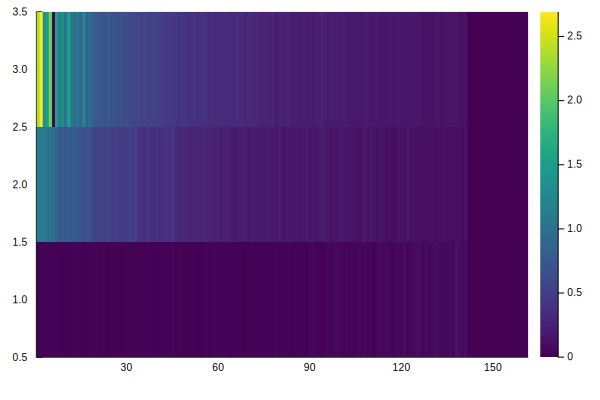

In [165]:
heatmap(rel_entropy, color=:viridis)

In [155]:
rel_entropy

3×161 Array{Float64,2}:
 0.000354089  0.0246864   0.00214839  …  0.0840345  0.060392   0.0909744
 9.07229      4.47305     3.88818        0.111062   0.0763845  0.113341
 0.00673238   0.00328868  0.00363629     0.106183   0.10777    0.129633

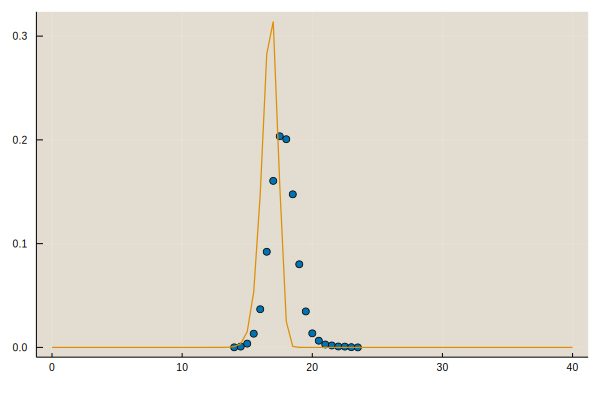

In [167]:
x, y = x_fix_list[end][end-120], y_fix_list[end][end-120]
scatter(x, y/sum(y))
x, y = Q(80, n, l_0, gap, f0, fl, 10)
plot!(x, y/sum(y))

In [160]:
rel_entropy[3, end-100]

0.4927453697790346